# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

### 1. Obtaining the Data

In [2]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [3]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


### 2. Preprocessing the Data

*Dropping Records*

In [6]:
# handling NaN records in specific column
df = df.dropna(axis=0, subset=['Genre'])

*Dropping Columns*

In [7]:
# dropping columns
df = df.drop(axis=1, columns=['Id', 'Platform', 'Year_of_Release', 'Publisher', 
                              'Critic_Count', 'User_Count', 'Developer', 'Rating'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 0 to 11702
Data columns (total 5 columns):
NA_Sales        11701 non-null float64
Genre           11701 non-null object
JP_Sales        11701 non-null float64
Critic_Score    5697 non-null float64
User_Score      7011 non-null object
dtypes: float64(3), object(2)
memory usage: 548.5+ KB


*Handling NaN's in `Critic_Score`*

In [9]:
round(df['Critic_Score'].isna().sum()/len(df), 3)

0.513

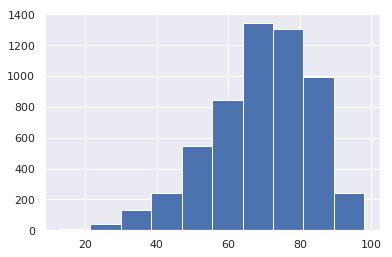

In [10]:
df.Critic_Score.hist();

In [11]:
df.Critic_Score.describe()

count    5697.000000
mean       68.909602
std        14.052323
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

In [12]:
# replace NaN's with value '100' as this doesn't exist in the real data (see above)
df['Critic_Score'].fillna(100, inplace=True)

# bin values into intervales/categories according to their percentiles
bins   = [13, 60, 71, 79, 98, 100]
labels = ['Q1', 'Q2', 'Q3', 'Q4', 'unknown']
df['Critic_Score_binned'] = pd.cut(df['Critic_Score'], bins=bins, labels=labels, include_lowest=True)

# drop original critic_score column
df = df.drop(axis=1, columns=['Critic_Score'])

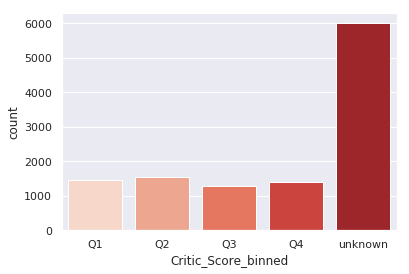

In [13]:
sns.countplot(x="Critic_Score_binned", data=df, palette="Reds");

*Handling NaN's in `User_Score`*

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 0 to 11702
Data columns (total 5 columns):
NA_Sales               11701 non-null float64
Genre                  11701 non-null object
JP_Sales               11701 non-null float64
User_Score             7011 non-null object
Critic_Score_binned    11701 non-null category
dtypes: category(1), float64(2), object(2)
memory usage: 788.7+ KB


In [15]:
round(df['User_Score'].isna().sum()/len(df), 3)

0.401

In [16]:
df['User_Score'].unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '2', '1.6', '1.2', '0.9', '0.7', '0.6', '2.3', '1.3', '0.2'],
      dtype=object)

In [17]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df['User_Score'].describe()

count    5332.000000
mean        7.125075
std         1.491034
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: User_Score, dtype: float64

In [18]:
# replace NaN's with value '10' as this doesn't exist in the real data (see above)
df['User_Score'].fillna(10, inplace=True)

# bin values into intervales/categories according to their percentiles
bins   = [0, 6.4, 7.5, 8.2, 9.7, 10]
labels = ['Q1', 'Q2', 'Q3', 'Q4', 'unknown']
df['User_Score_binned'] = pd.cut(df['User_Score'], bins=bins, labels=labels, include_lowest=True)

# drop original critic_score column
df = df.drop(axis=1, columns=['User_Score'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 0 to 11702
Data columns (total 5 columns):
NA_Sales               11701 non-null float64
Genre                  11701 non-null object
JP_Sales               11701 non-null float64
Critic_Score_binned    11701 non-null category
User_Score_binned      11701 non-null category
dtypes: category(2), float64(2), object(1)
memory usage: 708.9+ KB


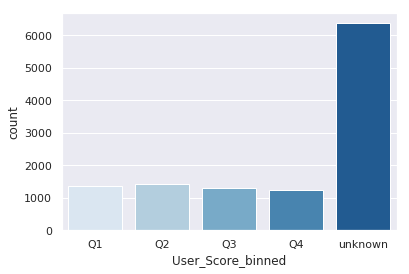

In [19]:
sns.countplot(x="User_Score_binned", data=df, palette="Blues");

In [20]:
#df['Platform'].value_counts()

## 3. Machine Learning

*Preparing Target & Features*

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 0 to 11702
Data columns (total 5 columns):
NA_Sales               11701 non-null float64
Genre                  11701 non-null object
JP_Sales               11701 non-null float64
Critic_Score_binned    11701 non-null category
User_Score_binned      11701 non-null category
dtypes: category(2), float64(2), object(1)
memory usage: 708.9+ KB


In [22]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [23]:
# convert string values in genre column into categorical values
df['Genre'] = df['Genre'].astype('category')

In [24]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [25]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*XGBoost*

In [26]:
# create a baseline
booster = xgb.XGBRegressor()

In [79]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


In [27]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, 
                           max_depth=7, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [28]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.5171
r2: 0.3628
